## Setup

In [24]:
# imports
import os, psycopg2, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from dotenv import load_dotenv

In [2]:
# database setup
db = 'order_mgmt'

# pull credentials from .env
load_dotenv('../.env')

dsn = f'''
dbname={db} 
user={os.getenv('super_user')} 
password={os.getenv('pg_password')} 
host={os.getenv('host')} 
port={os.getenv('port')}
'''

### Get data from database

In [8]:
# connect to database to create dataframe
with psycopg2.connect(dsn) as conn, conn.cursor() as cur:
    # get one record per purchase
    cur.execute(
        '''
        SELECT 	o.order_no,
		        o.customer_id,
                o.order_date,
                -- SUM(ol.quantity) AS total_quantity,
                SUM(ol.sales) AS total_sales
        FROM orders o
        JOIN order_lines ol USING (order_no)
        WHERE o.status IN 
            ('Shipped', 'Resolved')
        GROUP BY o.order_no, o.customer_id, o.order_date
        ORDER BY o.order_no
        '''
    )

    # fetch data
    records = cur.fetchall()
    fields = [field.name for field in cur.description]

    # setup dataframe
    df = pd.DataFrame(records, columns=fields)

In [9]:
# display data
df.head()

,order_no,customer_id,order_date,total_sales
0,10100,15,2003-01-06,12133.25
1,10101,51,2003-01-09,11432.34
2,10102,42,2003-01-10,6864.05
3,10103,65,2003-01-29,54702.00
4,10104,37,2003-01-31,44621.96


# Preprocessing
---

## Update data types

In [10]:
# data types
df.dtypes

order_no        int64
customer_id     int64
order_date     object
total_sales    object
dtype: object

In [11]:
# update data types
df.total_sales = pd.to_numeric(df.total_sales)
df.order_date = pd.to_datetime(df.order_date)

In [12]:
# double check dtypes
df.dtypes

order_no                int64
customer_id             int64
order_date     datetime64[ns]
total_sales           float64
dtype: object

## Get RFM (Recency, Frequency, Monetary)

For each customer:
- Recency: number of days between "present" date and date of last purchase
- Frequency: number of orders
- Monetary: sum of purchase price

In [31]:
# calculate recency, frequency, monetary for each customer
recent_date = df.order_date.max()
rfm_df = df.groupby('customer_id').agg({
    'order_date': lambda date: (recent_date - date.max()).days,
    'order_no': lambda orders: len(orders),
    'total_sales': lambda sale: sale.sum()
})

# update columns
rfm_cols = ['recency', 'frequency', 'monetary']
rfm_df.columns = rfm_cols
#rfm_df = rfm_df.reset_index()

# display
rfm_df.head()

,recency,frequency,monetary
customer_id,,,
1,183,3,118711.78
2,213,2,100306.58
3,188,4,119028.73
4,441,3,142874.25
5,132,4,120783.07


## Check outliers/distribution

#### **Analysis:**
Recency: mild right skew--> most customers bought at around same time 
- Outliers: 4 (upper) 
- Percentiles: 99th percentile is 1.08 times greater than 95th percentile
- Skew: 0.769 
- Mean > Median --> 189.05 > 181.0

Frequency: heavy right skew driven by a few very active/loyal customers (good to look into outliers since they more than triple the 95th percentile)
- Outliers: 5 (upper)  
- Percentiles: 99th percentile is 3.74 times greater than 95th percentile
- Skew: 6.138
- Mean > Median: 3.15 > 3.0

Monetary: heavy right skew with a few high spending customers (good to look into since they're four times the 95th percentile)
- Outliers: 4 (upper)
- Percentiles: 99th percentile is 4.01 times greater than 95th percentile
- Skew: 5.393
- Mean > Median: 102,632.82 > 85,360.0

OVERALL:
- Overall, all RFM measures are right skewed but mainly Frequency and Monetary driven by high activity/spenders; recency is only mildly skewed
- Keep outliers as they are valid and important to understand (transforming/scaling will prevent them from dominating before modeling)

#### Outliers

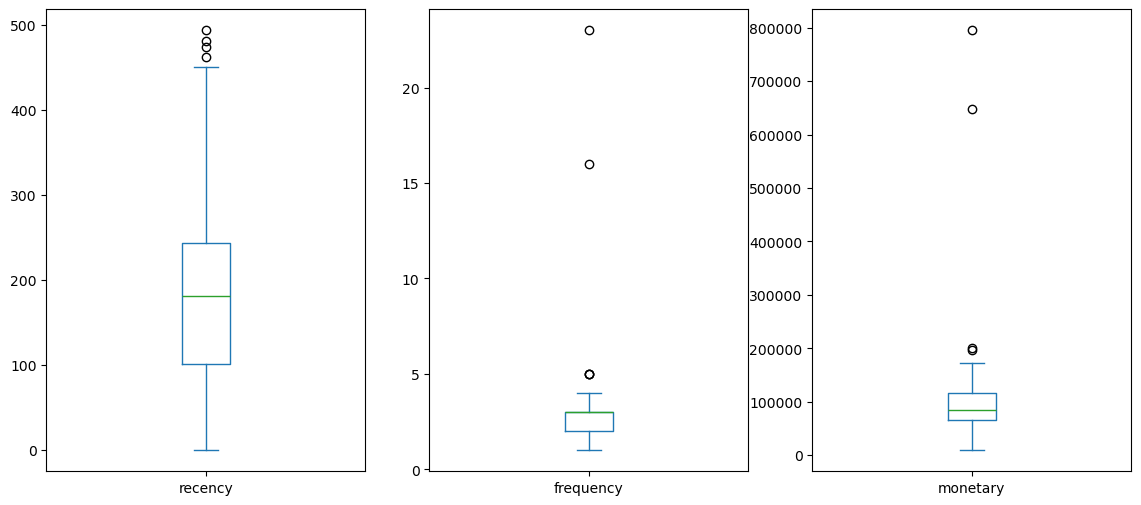

In [90]:
# boxplots
rfm_df.plot(kind='box', subplots=True, figsize=(14,6))
plt.show()

In [ ]:
# number of outliers
for rfm_col in rfm_cols:
    # calculate iqr
    col = rfm_df[rfm_col]
    q1, q3 = col.quantile([.25, .75])
    iqr = q3 - q1

    # find outliers
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    l_outliers = (col < lower).sum()
    u_outliers = (col > upper).sum()

    # display
    print('-'*30)
    print(rfm_col.upper())
    print(f'\nNumber of outliers: {l_outliers + u_outliers}')
    print(f'Upper: {u_outliers}')
    print(f'Lower: {l_outliers}')
    print('-'*30)

------------------------------
RECENCY

Number of outliers: 4
Upper: 4
Lower: 0
------------------------------
------------------------------
FREQUENCY

Number of outliers: 5
Upper: 5
Lower: 0
------------------------------
------------------------------
MONETARY

Number of outliers: 4
Upper: 4
Lower: 0
------------------------------


### Distribution

In [ ]:
# compare percentiles (mainly 95% and 99%)
percentiles = rfm_df.quantile([.25,.5,.75,.9,.95,.99])
display(percentiles)

for col in rfm_cols:

    # calculate top 1% and top 5%
    top_1 = percentiles.loc[0.99, col]
    top_5 = percentiles.loc[0.95, col]

    # display
    print(col.upper())
    print(f'top 1: {top_1}')
    print(f'top 5: {top_5}')
    print(f'99th percentile is {round(top_1/top_5,2)} times greater than 95th percentile')
    print('-'*30)

,recency,frequency,monetary
0.25,101.75,2.00,66129.0075
0.50,181.00,3.00,85360.0000
0.75,243.25,3.00,115616.8825
0.90,385.20,4.00,142846.9580
0.95,448.25,4.45,164639.6515
0.99,482.17,16.63,660892.1819


RECENCY
top 1: 482.1700000000001
top 5: 448.25
99th percentile is 1.08 times greater than 95th percentile
------------------------------
FREQUENCY
top 1: 16.630000000000024
top 5: 4.450000000000003
99th percentile is 3.74 times greater than 95th percentile
------------------------------
MONETARY
top 1: 660892.1819000005
top 5: 164639.65150000007
99th percentile is 4.01 times greater than 95th percentile
------------------------------


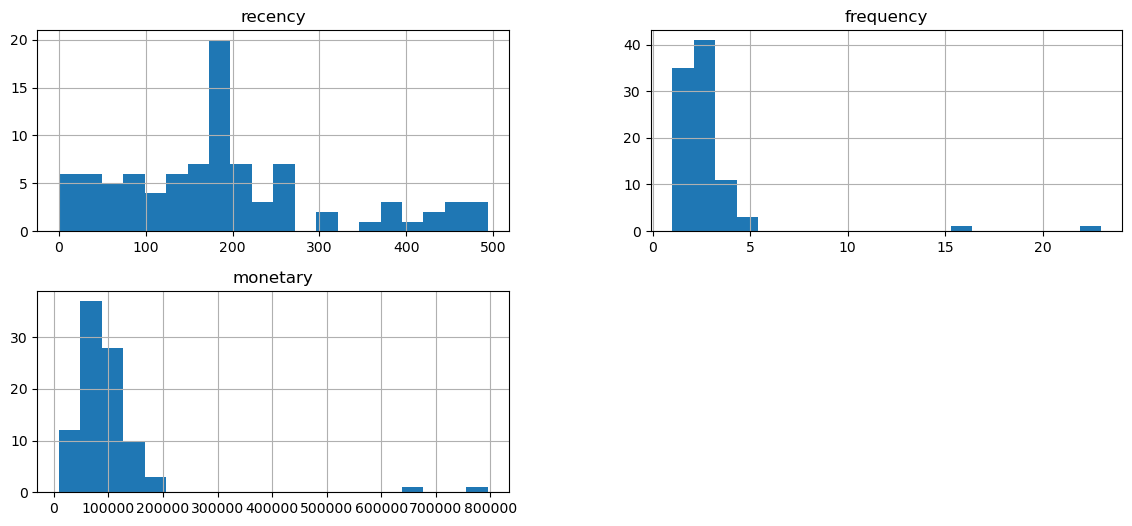

In [91]:
# histograms
rfm_df[rfm_cols].hist(bins=20, figsize=(14,6))
plt.show()

In [ ]:
# find skewness and compare mean with median (mean > median --> right skew)
for col in rfm_cols:
    print(col.upper())
    print(f'Skewness: {rfm_df[col].skew()}')
    print(f'\nMean: {rfm_df[col].mean()}')
    print(f'Median: {rfm_df[col].median()}')
    print('-'*30)

RECENCY
Skewness: 0.7692197491282079

Mean: 189.05434782608697
Median: 181.0
------------------------------
FREQUENCY
Skewness: 6.138049494790223

Mean: 3.152173913043478
Median: 3.0
------------------------------
MONETARY
Skewness: 5.392615515812862

Mean: 102632.8191304348
Median: 85360.0
------------------------------
